# auto feature engineering on twitter recsys

* ### [example 1](#Example-1): use Featuretools to process, enrich from 21 features 25 features, took 350secs, unable to decode text token
* ### [example 2](#Example-2): use RecDP w/pandas to process, enrich from 21 features to 41 features, took 1967 secs, do text decode
* ### [example 3](#Example-3): use RecDP w/spark to process, enrich from 21 features to 41 features, took 245 secs, do text decode

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14461760 entries, 33697 to 11721117
Data columns (total 22 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   id                                  int64         
 1   text_tokens                         string        
 2   hashtags                            string        
 3   tweet_id                            string        
 4   present_media                       category      
 5   present_links                       string        
 6   present_domains                     string        
 7   tweet_type                          category      
 8   language                            category      
 9   tweet_timestamp                     datetime64[ns]
 10  engaged_with_user_id                string        
 11  engaged_with_user_follower_count    int64         
 12  engaged_with_user_following_count   int64         
 13  engaged_with_user_is_verified       

# Example 1

### Use Featuretools to process 14,000,000+ rows, enrich from 21 features to 23 features, 

In [19]:
import pandas as pd
from utils import Timer
import featuretools as ft
from featuretools.primitives.base import TransformPrimitive
from woodwork.logical_types import NaturalLanguage

with Timer("read train data from csv"):
    train_data = pd.read_csv("twitter_recsys_cleaned.csv")
    print(f"train_data shape is {train_data.shape}")

with Timer("Load data to entityset"):
    es = ft.EntitySet("twitter_recsys_reply")
    logical_types = {
        'text_tokens': NaturalLanguage,
    }
    es.add_dataframe(dataframe_name="main",
                     dataframe=train_data,
                     index="id",
                     time_index='tweet_timestamp',
                     logical_types = logical_types)
    
with Timer("DFS feature generation"):
    cutoff_time = es['main'][['id', 'tweet_timestamp']]
    # calculate feature_matrix using deep feature synthesis
    ret_df, features = ft.dfs(entityset=es,
                              target_dataframe_name="main",
                              trans_primitives=trans_primitives,
                              verbose=True,
                              cutoff_time=cutoff_time,
                              approximate='36d',
                              max_depth=3,
                              max_features=40)
ret_df

train_data shape is (14461760, 21)
read train data from csv took 97.51098210178316 sec


/usr/local/lib/python3.8/dist-packages/featuretools/entityset/entityset.py:1906: UserWarning: index id not found in dataframe, creating new integer column
  warnings.warn(


Load data to entityset took 90.19245634134859 sec


/usr/local/lib/python3.8/dist-packages/featuretools/synthesis/deep_feature_synthesis.py:170: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/featuretools/synthesis/dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['decoded', 'haversine']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Built 25 features
Elapsed: 04:14 | Progress: 100%|██████████
DFS feature generation took 261.04354946501553 sec


,present_media,tweet_type,language,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,engagee_follows_engager,...,MONTH(engaging_user_account_creation),MONTH(tweet_timestamp),NUM_CHARACTERS(text_tokens),NUM_WORDS(text_tokens),WEEKDAY(engaged_with_user_account_creation),WEEKDAY(engaging_user_account_creation),WEEKDAY(tweet_timestamp),YEAR(engaged_with_user_account_creation),YEAR(engaging_user_account_creation),YEAR(tweet_timestamp)
id,,,,,,,,,,,,,,,,,,,,,
33697,Photo\tPhoto\tPhoto,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,488344,1034,True,74,634,False,False,...,9,2,402.0,1.0,6,5,3,2012,2019,2021
51664,Photo\tPhoto,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,169508,51,True,508,960,False,False,...,9,2,107.0,1.0,3,1,3,2009,2019,2021
76394,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,565629,708,True,126,395,False,False,...,10,2,243.0,1.0,2,1,3,2012,2009,2021
151574,NaN,TopLevel,9A78FC330083E72BE0DD1EA92656F3B5,486913,2,False,7740,653,False,False,...,5,2,595.0,1.0,0,4,3,2014,2012,2021
189084,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,977108,305,True,127,718,False,False,...,5,2,75.0,1.0,3,0,3,2009,2017,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6582509,NaN,Retweet,B0FA488F2911701DD8EC5B1EA5E322D8,125,126,False,35,49,False,True,...,8,3,154.0,1.0,0,6,2,2019,2020,2021
9390569,NaN,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,2174726,2067,True,223,788,False,False,...,5,3,208.0,1.0,1,6,2,2009,2012,2021
9793351,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,100886,984,False,20,64,False,False,...,8,3,414.0,1.0,6,5,2,2010,2020,2021


In [21]:
ret_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14461760 entries, 33697 to 11721117
Data columns (total 25 columns):
 #   Column                                       Dtype   
---  ------                                       -----   
 0   present_media                                category
 1   tweet_type                                   category
 2   language                                     category
 3   engaged_with_user_follower_count             int64   
 4   engaged_with_user_following_count            int64   
 5   engaged_with_user_is_verified                bool    
 6   engaging_user_follower_count                 int64   
 7   enaging_user_following_count                 int64   
 8   enaging_user_is_verified                     bool    
 9   engagee_follows_engager                      bool    
 10  reply                                        int64   
 11  DAY(engaged_with_user_account_creation)      category
 12  DAY(engaging_user_account_creation)          categ

# Example 2

### Use RecDP w/pandas to process 14,000,000+ rows, enrich from 21 features to 41 features, took about 1967secs

In [2]:
import sys
sys.path.append('../../../')

import pandas as pd
from utils import Timer

with Timer("read train data from csv"):
    train_data = pd.read_csv("twitter_recsys_cleaned.csv")
    print(f"train_data shape is {train_data.shape}")

from pyrecdp.autofe import FeatureWrangler
with Timer("initiate autofe pipeline"):
    pipeline = FeatureWrangler(dataset=train_data, label="reply")

with Timer("transform"):
    ret = pipeline.fit_transform(engine_type = 'pandas')
    
print(f"transformed shape is {ret.shape}")
ret

train_data shape is (14461760, 21)
read train data from csv took 102.69935449492186 sec


/home/vmagent/app/recdp/pyrecdp/core/dataframe.py:30: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'may_sample' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def may_sample(df):


initiate autofe pipeline took 3.083546308800578 sec
Transformation of <function DataframeConvertFeatureGenerator.get_function_pd.<locals>.convert_df at 0x7f1cd541d940> took 0.000 secs
Transformation of <function FillNaFeatureGenerator.get_function_pd.<locals>.fill_na at 0x7f111dad1160> took 0.596 secs
Transformation of <function TypeInferFeatureGenerator.get_function_pd.<locals>.type_infer at 0x7f111dad1430> took 39.585 secs


2023-01-11 17:23:51.977504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 17:23:52.114974: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Transformation of <function FeaturetoolsBasedFeatureGenerator.get_function_pd.<locals>.generate_ft_feature at 0x7f111dad10d0> took 1539.168 secs
Transformation of <function FeaturetoolsBasedFeatureGenerator.get_function_pd.<locals>.generate_ft_feature at 0x7f111dad14c0> took 34.373 secs
Transformation of <function FeaturetoolsBasedFeatureGenerator.get_function_pd.<locals>.generate_ft_feature at 0x7f111dad1550> took 353.720 secs
Transformation of <function DataframeTransformFeatureGenerator.get_function_pd.<locals>.transform_df at 0x7f111dad15e0> took 0.000 secs
transform took 1967.4441721253097 sec
transformed shape is (14461760, 41)


,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,engaged_with_user_account_creation.hour,engaged_with_user_account_creation.part_of_day,engaging_user_account_creation.day,engaging_user_account_creation.month,engaging_user_account_creation.weekday,engaging_user_account_creation.year,engaging_user_account_creation.hour,engaging_user_account_creation.part_of_day,text_tokens.decoded.number_of_unique_words,text_tokens.decoded.num_words
0,101\t157\t39554\t117\t51747\t10479\t27874\t101...,NaN,0C8E7372269942BB173EED7C0A72DA09,NaN,NaN,NaN,Quote,488B32D24BD4BB44172EB981C1BCA6FA,2021-02-28 14:49:42,8B7BB615A39DF112B0037E960C27F220,...,17,evening,28,12,6,2014,10,late morning,45,63
1,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,NaN,858720854891DFED04A5B91758049833,Photo,NaN,NaN,TopLevel,313ECD3A1E5BB07406E4249475C2D6D6,2021-02-26 10:30:36,74B09D5BC3FCE5CC4DEE34BF049A0EE5,...,18,evening,14,9,0,2020,4,dawn,6,10
2,101\t56898\t137\t10279\t10908\t10138\t168\t398...,90C52DDF506D1C98EE678E84C08C36AB\tCD8639BABE54...,1988AA4069C46F57990B6983FBD427A6,NaN,D249E94F6D37A7D5E37185E02C94CDFF,9EFF000CDB18B710CDDB43EE1D8C300B,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-01 17:02:33,316C2BE47E445DA930E56C12F3AF31C5,...,3,midnight,1,11,6,2009,11,noon,44,71
3,101\t56898\t137\t12275\t10738\t11534\t15417\t9...,D704B4128E35F9BC995E701523676542\tCFD3AF9039C6...,89C86150124016236B7D4A286B041210,NaN,NaN,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-02 19:55:32,C19FC40FBF0AA0BAC4797BD47483349B,...,5,dawn,10,9,3,2020,8,late morning,45,72
4,101\t109821\t24093\t14703\t30118\t11259\t160\t...,NaN,971197A8E595128D8BAF8F3F9D20CFF3,Photo\tPhoto,NaN,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,2021-03-01 00:38:33,46846BF25E56F8BA11C0AE36ED31B28F,...,22,night,29,7,6,2018,15,afternoon,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14461755,101\t119\t137\t94901\t13034\t26660\t11420\t115...,017E205D5D29FF50A65A51E97A46BD61,11BE8A3BE71A9CA1441E248938AEF806,Photo,NaN,NaN,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,2021-03-03 17:59:38,DD027766554EE8442B0486558D89A068,...,21,night,18,7,1,2017,21,night,16,22
14461756,101\t15973\t10245\t12352\t24023\t10173\t24143\...,NaN,24E75F338646775712D6EAD8BEABAA12,NaN,NaN,NaN,Quote,B0FA488F2911701DD8EC5B1EA5E322D8,2021-02-26 00:55:42,EAB01AB6A0838F29087ABD7C647DC859,...,19,evening,19,5,0,2008,15,afternoon,14,15
14461757,101\t56898\t137\t75335\t11537\t26127\t11183\t4...,NaN,C562DB647BD28D896CAB8EDCAB9D3EC5,NaN,NaN,NaN,Retweet,5A0759FB938B1D9B1E08B7A3A14F1042,2021-03-02 08:24:51,21F53C1D54F6FB354E50CD45C8AD27EB,...,2,midnight,5,6,3,2014,5,dawn,8,10
14461758,101\t56898\t137\t150\t10425\t11090\t35906\t101...,D8139554BD6AE58A01AA772537EB7920,5E113B994FE4085535CAA8108FAA2649,NaN,NaN,NaN,Retweet,7F4FAB1EB12CD95EDCD9DB2A6634EFCE,2021-03-03 03:26:02,5A8FE2395F5A8D44F500DC4DA49754AB,...,17,evening,1,1,1,2019,16,afternoon,22,30


In [22]:
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14461760 entries, 0 to 14461759
Data columns (total 41 columns):
 #   Column                                          Dtype         
---  ------                                          -----         
 0   text_tokens                                     object        
 1   hashtags                                        object        
 2   tweet_id                                        object        
 3   present_media                                   object        
 4   present_links                                   object        
 5   present_domains                                 object        
 6   tweet_type                                      category      
 7   language                                        object        
 8   tweet_timestamp                                 datetime64[ns]
 9   engaged_with_user_id                            object        
 10  engaged_with_user_follower_count                int64         
 

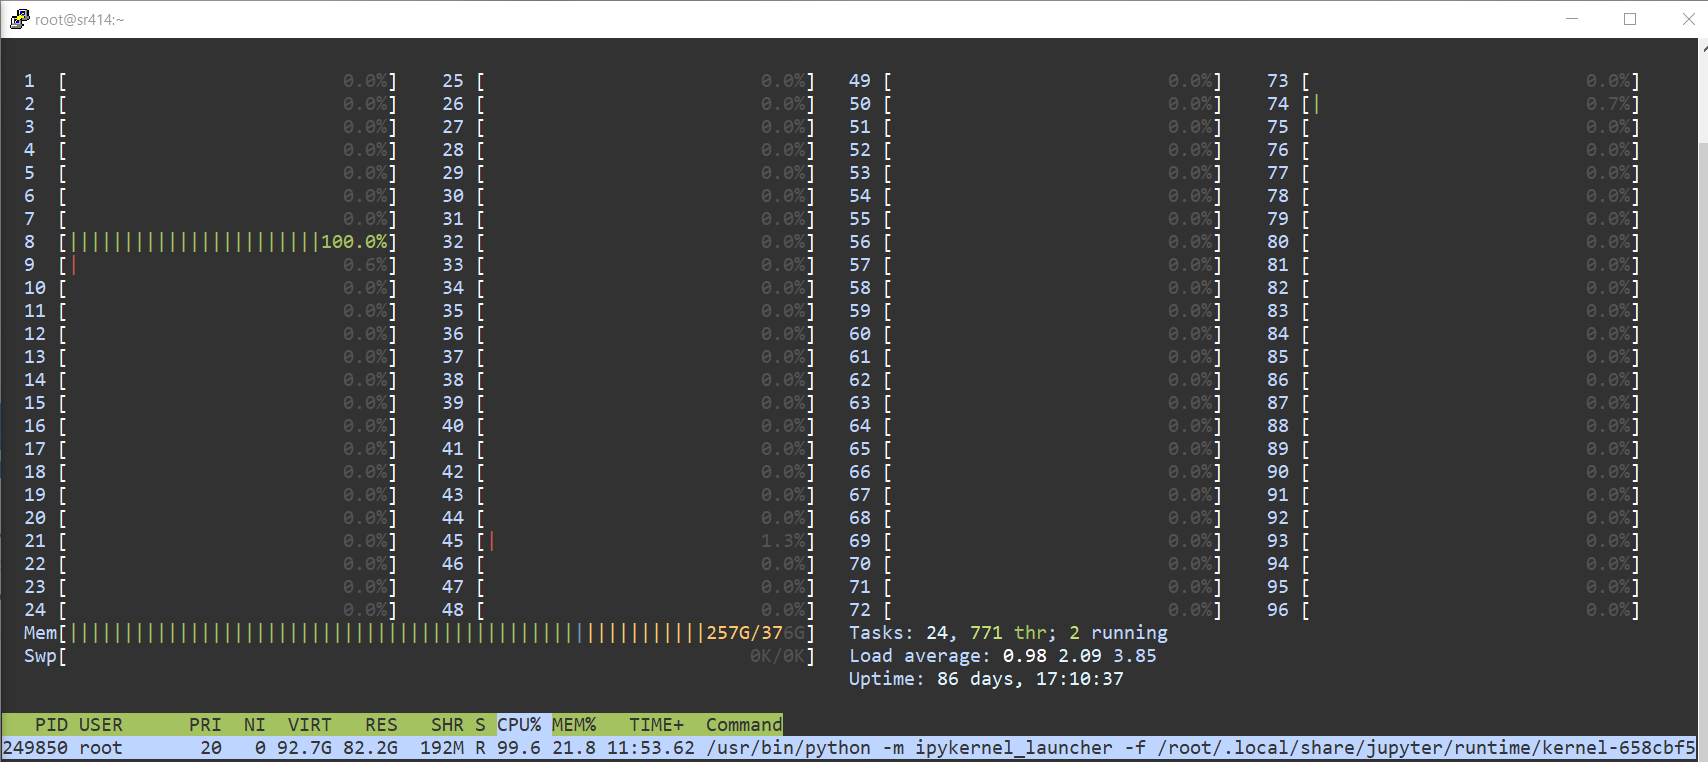

# Example 3

### Use RecDP w/spark to process 14,000,000+ rows, enrich from 21 features to 41 features, took about 245secs

In [1]:
import sys
sys.path.append('../../../')

import pandas as pd
from utils import Timer

with Timer("read train data from csv"):
    train_data = pd.read_csv("twitter_recsys_cleaned.csv")
    print(f"train_data shape is {train_data.shape}")

from pyrecdp.autofe import FeatureWrangler
with Timer("initiate autofe pipeline"):
    pipeline = FeatureWrangler(dataset=train_data, label="reply")

with Timer("transform"):
    ret = pipeline.fit_transform(engine_type = 'spark')
    
print(f"transformed shape is {ret.shape}")
ret

train_data shape is (14461760, 21)
read train data from csv took 95.63510756473988 sec


pipeline includes below steps:
["Stage 0: [<class 'pyrecdp.primitives.generators.dataframe.DataframeConvertFeatureGenerator'>]", "Stage 1: [<class 'pyrecdp.primitives.generators.fillna.FillNaFeatureGenerator'>, <class 'pyrecdp.primitives.generators.type.TypeInferFeatureGenerator'>, <class 'pyrecdp.primitives.generators.nlp.DecodedTextFeatureGenerator'>]", "Stage 2: [<class 'pyrecdp.primitives.generators.datetime.DatetimeFeatureGenerator'>, <class 'pyrecdp.primitives.generators.nlp.TextFeatureGenerator'>]", "Stage 3: [<class 'pyrecdp.primitives.generators.dataframe.DataframeTransformFeatureGenerator'>]", 'Stage 4: []', 'Stage 5: []', 'Stage 6: []']
initiate autofe pipeline took 2.7566409800201654 sec


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/12 05:19:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/12 05:19:18 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


per core memory size is 10.417 GB and shuffle_disk maximum capacity is 8589934592.000 GB


23/01/12 05:20:08 WARN TaskSetManager: Stage 0 contains a task of very large size (146949 KiB). The maximum recommended task size is 1000 KiB.


DataframeConvert partition pandas dataframe to spark RDD took 64.843 secs


23/01/12 05:20:27 WARN TaskSetManager: Stage 1 contains a task of very large size (146949 KiB). The maximum recommended task size is 1000 KiB.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. M

DataframeTransform took 155.940 secs, processed 14461760 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 10.494 secs
transform took 241.74589546956122 sec
transformed shape is (14461760, 41)


,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,engaged_with_user_account_creation.hour,engaged_with_user_account_creation.part_of_day,engaging_user_account_creation.day,engaging_user_account_creation.month,engaging_user_account_creation.weekday,engaging_user_account_creation.year,engaging_user_account_creation.hour,engaging_user_account_creation.part_of_day,text_tokens.decoded.number_of_unique_words,text_tokens.decoded.num_words
0,101\t157\t39554\t117\t51747\t10479\t27874\t101...,NaN,0C8E7372269942BB173EED7C0A72DA09,NaN,NaN,NaN,Quote,488B32D24BD4BB44172EB981C1BCA6FA,2021-02-28 14:49:42,8B7BB615A39DF112B0037E960C27F220,...,17,evening,28,12,6,2014,10,late morning,45,63
1,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,NaN,858720854891DFED04A5B91758049833,Photo,NaN,NaN,TopLevel,313ECD3A1E5BB07406E4249475C2D6D6,2021-02-26 10:30:36,74B09D5BC3FCE5CC4DEE34BF049A0EE5,...,18,evening,14,9,0,2020,4,dawn,6,10
2,101\t56898\t137\t10279\t10908\t10138\t168\t398...,90C52DDF506D1C98EE678E84C08C36AB\tCD8639BABE54...,1988AA4069C46F57990B6983FBD427A6,NaN,D249E94F6D37A7D5E37185E02C94CDFF,9EFF000CDB18B710CDDB43EE1D8C300B,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-01 17:02:33,316C2BE47E445DA930E56C12F3AF31C5,...,3,midnight,1,11,6,2009,11,noon,44,71
3,101\t56898\t137\t12275\t10738\t11534\t15417\t9...,D704B4128E35F9BC995E701523676542\tCFD3AF9039C6...,89C86150124016236B7D4A286B041210,NaN,NaN,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-02 19:55:32,C19FC40FBF0AA0BAC4797BD47483349B,...,5,dawn,10,9,3,2020,8,late morning,45,72
4,101\t109821\t24093\t14703\t30118\t11259\t160\t...,NaN,971197A8E595128D8BAF8F3F9D20CFF3,Photo\tPhoto,NaN,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,2021-03-01 00:38:33,46846BF25E56F8BA11C0AE36ED31B28F,...,22,night,29,7,6,2018,15,afternoon,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14461755,101\t119\t137\t94901\t13034\t26660\t11420\t115...,017E205D5D29FF50A65A51E97A46BD61,11BE8A3BE71A9CA1441E248938AEF806,Photo,NaN,NaN,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,2021-03-03 17:59:38,DD027766554EE8442B0486558D89A068,...,21,night,18,7,1,2017,21,night,16,22
14461756,101\t15973\t10245\t12352\t24023\t10173\t24143\...,NaN,24E75F338646775712D6EAD8BEABAA12,NaN,NaN,NaN,Quote,B0FA488F2911701DD8EC5B1EA5E322D8,2021-02-26 00:55:42,EAB01AB6A0838F29087ABD7C647DC859,...,19,evening,19,5,0,2008,15,afternoon,14,15
14461757,101\t56898\t137\t75335\t11537\t26127\t11183\t4...,NaN,C562DB647BD28D896CAB8EDCAB9D3EC5,NaN,NaN,NaN,Retweet,5A0759FB938B1D9B1E08B7A3A14F1042,2021-03-02 08:24:51,21F53C1D54F6FB354E50CD45C8AD27EB,...,2,midnight,5,6,3,2014,5,dawn,8,10
14461758,101\t56898\t137\t150\t10425\t11090\t35906\t101...,D8139554BD6AE58A01AA772537EB7920,5E113B994FE4085535CAA8108FAA2649,NaN,NaN,NaN,Retweet,7F4FAB1EB12CD95EDCD9DB2A6634EFCE,2021-03-03 03:26:02,5A8FE2395F5A8D44F500DC4DA49754AB,...,17,evening,1,1,1,2019,16,afternoon,22,30


In [22]:
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14461760 entries, 0 to 14461759
Data columns (total 41 columns):
 #   Column                                          Dtype         
---  ------                                          -----         
 0   text_tokens                                     object        
 1   hashtags                                        object        
 2   tweet_id                                        object        
 3   present_media                                   object        
 4   present_links                                   object        
 5   present_domains                                 object        
 6   tweet_type                                      category      
 7   language                                        object        
 8   tweet_timestamp                                 datetime64[ns]
 9   engaged_with_user_id                            object        
 10  engaged_with_user_follower_count                int64         
 

Run Time HTOP
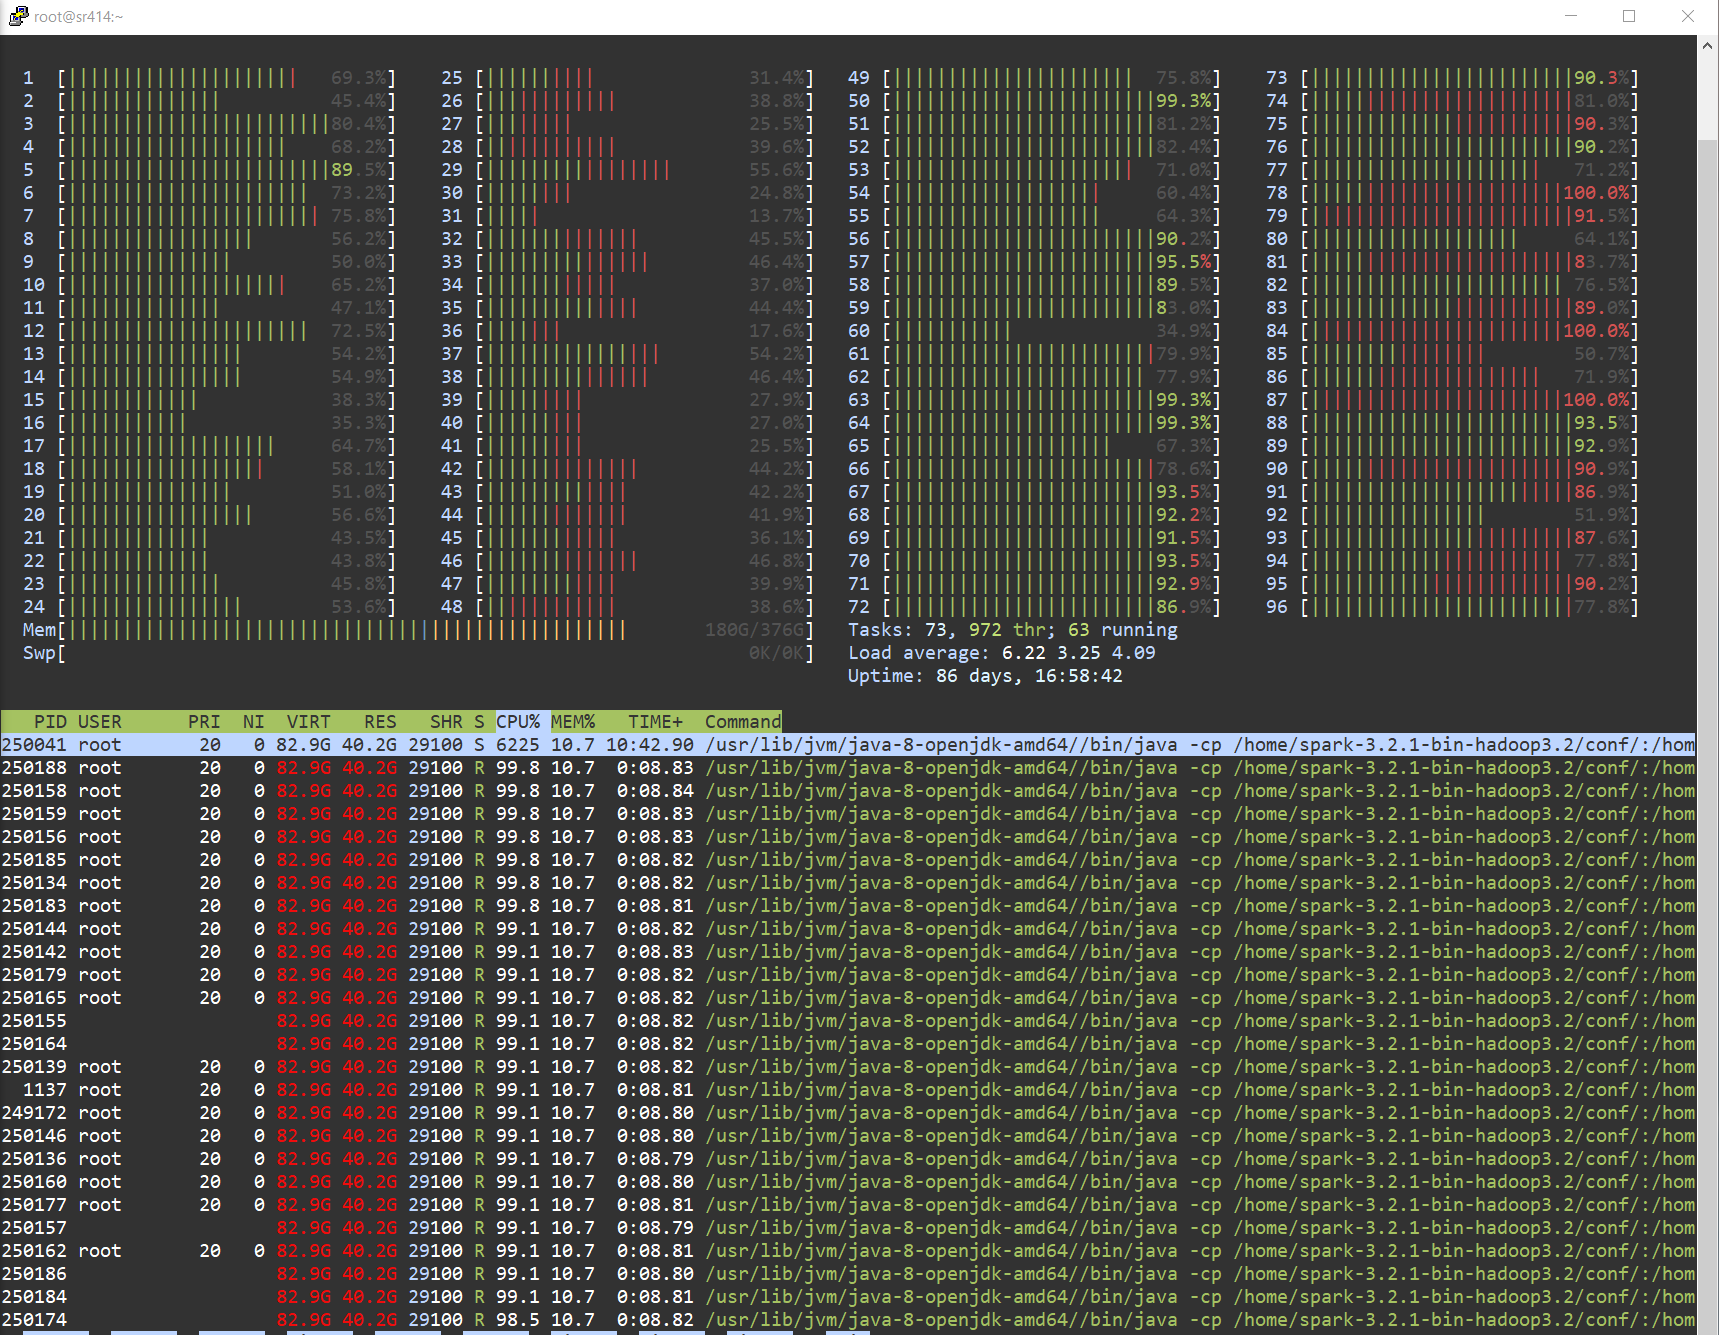

# Backup - Clean raw data add titles

In [1]:
import pandas as pd
from utils import Timer
import os

def clean_df(df, label = 'reply'):
    df['tweet_timestamp'] = pd.to_datetime(df['tweet_timestamp'],unit='s')
    df['engaging_user_account_creation'] = pd.to_datetime(df['engaging_user_account_creation'],unit='s')
    df['engaged_with_user_account_creation'] = pd.to_datetime(df['engaged_with_user_account_creation'],unit='s')
    
    df['reply'] = df['reply_timestamp'].apply(lambda x: 1 if x>0 else 0).astype('int32')
    df['retweet'] = df['retweet_timestamp'].apply(lambda x: 1 if x>0 else 0).astype('int32')
    df['comment'] = df['retweet_with_comment_timestamp'].apply(lambda x: 1 if x>0 else 0).astype('int32')
    df['like'] = df['like_timestamp'].apply(lambda x: 1 if x>0 else 0).astype('int32')
    df = df.drop(columns=['reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp','like_timestamp'])
    if 'tokens' in df.columns:
        df = df.drop(columns=['tokens'])
    return df

def apply_bert_decode(df):
    from transformers import BertTokenizer
    os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
    df["tweet"] = df["text_tokens"].progress_apply(lambda x: tokenizer.decode([int(n) for n in x.split('\t')]))
    df = df.drop(columns=['text_tokens'])
    return df

with Timer(f"read data"):
    schema = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains", "tweet_type",
        "language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count", "engaged_with_user_following_count",
        "engaged_with_user_is_verified", "engaged_with_user_account_creation", "engaging_user_id", "engaging_user_follower_count",
        "enaging_user_following_count", "enaging_user_is_verified", "engaging_user_account_creation", "engagee_follows_engager",
        "reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]
    train_data = pd.read_csv("twitter_recsys.csv", sep='\x01', names = schema, header=None,)
with Timer(f"clean data"):
    train_data = clean_df(train_data)
with Timer("write_data"):
    train_data.to_csv("twitter_recsys_cleaned.csv", index = False)

read data took 82.04026912152767 sec
clean data took 7.953582388348877 sec
write_data took 219.43907960969955 sec
